In [10]:
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
%matplotlib inline

from sklearn.preprocessing import RobustScaler

# import basic libraries 
import h5py
import pandas as pd

from keras.models import Model
from keras.layers import Input, add
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils


In [11]:
#Opening file
filename = "/uscms/home/jpearkes/eos/forAda/scouting_nano.root" # originally from root://hip-cms-se.csc.fi//store/user/pinkaew/scouting_nano_prod_golden/ScoutingPFRun3/crab_ScoutingPFRun3_Run2024D-v1_380385-380470_Golden/240517_205837/0000/scouting_nano_399.root
file = uproot.open(filename)

#Calling files
jet_pt = file["Events"]["L1Jet_pt"].array()
jet_eta = file["Events"]["L1Jet_eta"].array()
jet_phi = file["Events"]["L1Jet_phi"].array()



In [50]:
jet_pt = np.asarray(ak.fill_none(ak.pad_none(jet_pt, 4, clip=True), 0.0)) #replace missing values with none, increase value to target length with ak.pad_none
jet_eta = np.asarray(ak.fill_none(ak.pad_none(jet_eta, 4, clip=True), 0.0))
jet_phi = np.asarray(ak.fill_none(ak.pad_none(jet_phi, 4, clip=True), 0.0))

jet_eta.shape #np function that gives us shape of array - (rows, columns) - 4 columns bc we said so with ak.pad_none

(431555, 4)

In [53]:
dataset = np.hstack([jet_pt,jet_eta,jet_phi]) #puts all the arrays next to eachother
dataset

array([[ 2.30000000e+01,  2.20000000e+01,  1.80000000e+01, ...,
        -4.10705566e-01, -1.36767578e+00,  1.87060547e+00],
       [ 1.60000000e+01,  1.20000000e+01,  1.15000000e+01, ...,
         8.26538086e-01, -2.84667969e+00,  7.39501953e-01],
       [ 2.00000000e+01,  1.35000000e+01,  1.90000000e+01, ...,
        -6.26831055e-02,  1.34838867e+00,  2.47949219e+00],
       ...,
       [ 2.80000000e+01,  2.55000000e+01,  1.85000000e+01, ...,
        -1.01977539e+00,  2.91455078e+00,  3.91479492e-01],
       [ 2.14500000e+02,  9.70000000e+01,  8.10000000e+01, ...,
         3.04504395e-01,  1.52246094e+00,  5.65551758e-01],
       [ 2.15000000e+01,  1.90000000e+01,  1.90000000e+01, ...,
        -1.62866211e+00,  1.34838867e+00, -1.71557617e+00]])

In [52]:
# We want some data for training, some for validating, and some for testing
# Validating combats overfitting while testing analyzes the predictive power of the network
dataset_size = dataset.shape[0] #gives you number of rows
data_train = dataset[0:int(dataset_size/2)] #50%
data_valid = dataset[int(dataset_size/2):int(dataset_size/4*3)] # 25% - used for tuning hyper-parameters
data_test = dataset[int(dataset_size/4*3):] # 25% - hold out for now

print(data_train.shape,data_test.shape, data_valid.shape)



(215777, 12) (107889, 12) (107889, 12)


In [15]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        print(batch)
        dim = tf.shape(z_mean)[1]
        print(dim)
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
#Encoder

latent_dim = 4

encoder_inputs = keras.Input(shape=(12))
x = layers.Normalization(mean=np.mean(data_train,axis=0),variance=np.std(data_train,axis=0), axis=-1, invert = False)(encoder_inputs)
x1 = layers.Dense(32, activation="relu")(x)
x2 = layers.Dense(16, activation="relu")(x1)
x3 = layers.Dense(8, activation="relu")(x2)
z_mean = layers.Dense(latent_dim, name="z_mean")(x3)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x3)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

#Decoder

latent_inputs = keras.Input(shape=(latent_dim,))
x4 = layers.Dense(16, activation="relu")(latent_inputs)
norm_layer_1 = layers.BatchNormalization(name="norm_1")(x4)
x5 = layers.Dense(32, activation="relu")(norm_layer_1)
norm_layer_2 = layers.BatchNormalization(name="norm_2")(x5)
x6 = layers.Dense(64, activation="relu")(norm_layer_2)
norm_layer_3 = layers.BatchNormalization(name="norm_3")(x6)
x7 = layers.Dense(128, activation="relu")(norm_layer_3)
x8 = layers.Dense(12,kernel_initializer='zeros', activation='linear')(x7)
decoder_outputs = tf.keras.layers.Normalization(mean=np.mean(data_train,axis=0),variance=np.std(data_train,axis=0), axis=-1, invert = True)(x8)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

#Build Model

class VAE(keras.Model):
    def __init__(self, encoder, decoder,alpha = 1, beta = 0.001, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        self.reco_scale = alpha * (1 - beta)
        self.kl_scale = beta
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.total_val_loss_tracker = keras.metrics.Mean(name="total_val_loss")
        self.reconstruction_val_loss_tracker = keras.metrics.Mean(name="val_reco_loss")
        self.kl_val_loss_tracker = keras.metrics.Mean(name="val_kl_loss")


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    

    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            #MSE = keras.losses.MeanSquaredLogarithmicError(reduction="auto", name="mean_squared_error")
            #MSE = keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
            MSE = keras.losses.MeanSquaredError(reduction="none", name="mean_squared_error")
            reconstruction_loss = self.reco_scale * tf.reduce_mean(tf.reduce_sum(MSE(data,reconstruction)))
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = self.kl_scale * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        
        #MSE = keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
        MSE = keras.losses.MeanSquaredError(reduction="none", name="mean_squared_error")
        reconstruction_loss = self.reco_scale* tf.reduce_mean(tf.reduce_sum(MSE(data,reconstruction)))
                    
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = self.kl_scale * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        
        total_loss = reconstruction_loss + kl_loss
        
        self.total_val_loss_tracker.update_state(total_loss)
        self.reconstruction_val_loss_tracker.update_state(reconstruction_loss)
        self.kl_val_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_val_loss_tracker.result(),
            "reco_loss": self.reconstruction_val_loss_tracker.result(),
            "kl_loss": self.kl_val_loss_tracker.result()

      }

Tensor("sampling_1/strided_slice:0", shape=(), dtype=int32)
Tensor("sampling_1/strided_slice_1:0", shape=(), dtype=int32)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 normalization_2 (Normalization  (None, 12)          0           ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 dense_8 (Dense)                (None, 32)           416         ['normalization_2[0][0]']        
                                                                     

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0, patience=5, verbose = 1,restore_best_weights=True)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001,clipnorm=10.0))
history = vae.fit(data_train, validation_data = (data_valid, data_valid), epochs=10, batch_size=16, callbacks = [callback],shuffle=False)

Epoch 1/10
Tensor("encoder/sampling_1/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling_1/strided_slice_1:0", shape=(), dtype=int32)
Tensor("encoder/sampling_1/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling_1/strided_slice_1:0", shape=(), dtype=int32)
13470/13487 [============================>.] - ETA: 0s - loss: 7991867829951782153355264.0000 - reconstruction_loss: 5210444849090660115939328.0000 - kl_loss: 24401651198998326804480.0000Tensor("encoder/sampling_1/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling_1/strided_slice_1:0", shape=(), dtype=int32)
13487/13487 [==============================] - 28s 2ms/step - loss: 7988183637514045259513856.0000 - reconstruction_loss: 5203877231739667212140544.0000 - kl_loss: 24370893865343200002048.0000 - val_loss: 1749710.5000 - val_reco_loss: 1749612.3750 - val_kl_loss: 97.7280
Epoch 2/10
13487/13487 [==============================] - 27s 2ms/step - loss: 818.4086 - reconstruction_loss: 430.90

In [17]:
z_mean, z_log_var, z = vae.encoder.predict(data_valid)
output = vae.decoder.predict(z)

Tensor("encoder/sampling_1/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling_1/strided_slice_1:0", shape=(), dtype=int32)
3372/3372 [==============================] - 3s 731us/step


dict_keys(['loss', 'reconstruction_loss', 'kl_loss', 'val_loss', 'val_reco_loss', 'val_kl_loss'])


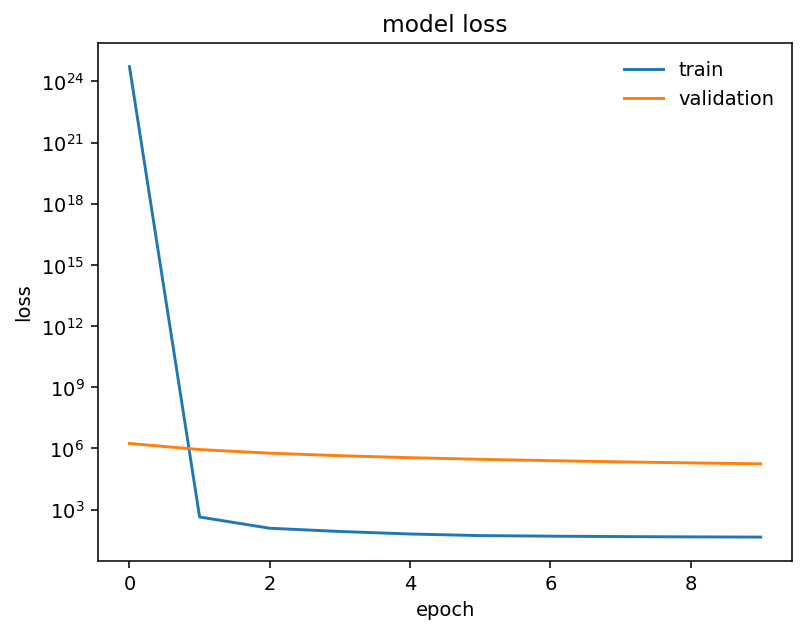

In [54]:
print(history.history.keys())

plt.plot(history.history['loss'],label="train")
plt.plot(history.history['val_loss'],label="validation")
#plt.yscale('log')
plt.title('model loss')
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper right',frameon = False)
plt.show()


(107889, 4, 3) (107889, 12) (107889, 12)


Text(0.5, 1.0, '1st Jet')

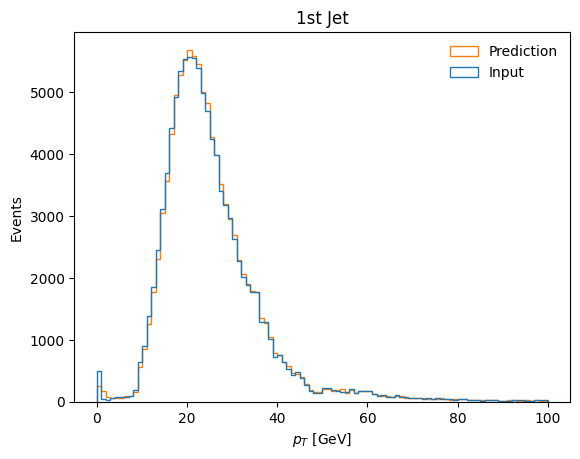

In [19]:
decoded_data = output.reshape(output.shape[0], 4,3) # Do the three dimensions correspond to the three variables? Bc I feel like no
data_valid_reshaped = data_valid.reshape(data_valid.shape[0], 4,3)

print(decoded_data.shape,data_test.shape, data_valid.shape)

#Jet Pt plot
plt.figure()
plt.rcParams['figure.dpi'] = 140
plt.hist([data_valid_reshaped[:,0,0],decoded_data[:,0,0]],bins=100,histtype='step',range = (0,100), label = ['Input','Prediction'])
plt.xlabel(r"$p_T$ [GeV]")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('1st Jet')

#But hey this looks great! Interesting jump at 0 GeV?

# Notes

**Might need to check the dataset shapes here**

Everything ran fine, with the exception of the model loss? It seems odd that validation = 0 for so much longer than training period.

**What is the training step doing?** 

The training step relies on the 50% of data that we set aside in the beginning. We've defined a loss function that we want to minimize (I assume) and the Gradient Tape gives us more control over the layer we've defined ([Source](https://stackoverflow.com/questions/53953099/what-is-the-purpose-of-the-tensorflow-gradient-tape)). The "trainable weights" change throughout the process so as to minimize loss.

How do the trainable weights actually change? Just it just try out a bunch of different configurations?

**What are hyperparameters and what happen when you change them?** 

Hyperparameters are settings that determine how the neural networks learn ([Source](https://pyimagesearch.com/2021/05/31/hyperparameter-tuning-for-deep-learning-with-scikit-learn-keras-and-tensorflow/)). Here, we have qualities like learning rate, batch size, and number of epochs.
- Patience: How many epochs to continue running even if model is not improving ([Source](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/))
- Verbose: When verbose = 1, program will return the number of the epoch that the network stopped at (Source above). 
- Epochs: Increasing the epoch size gives the program more training opportunities, thereby minimizing the loss even more. However, it does increase computation time. I increased the epoch size to 15, and it stopped it after 7/15 runs, with a 37.1% loss. However, this was also considering the training from the last 10 epochs. When I graphed the model loss, train decreased while validation increased.
- Learning rate: Changing the learning rate from 0.0001 to 0.1 had massively high loss rates (Epoch 2/10 had about 34200) and disastrous correlation on the 1st jet plot. I imagine that making the learning rate smaller would give better results, but take very long. 
- Batch Size: Resetting learning rate and changing the batch size from 16 to 8 increased the computation time and also had pretty bad loss (although, this could be from the aftermath of the learning rate). 

**How well does the input compare with the predictions?** 

With the given hyperparameters, very well! There is a peak in the input at ~0 GeV that is unanticipated, but beyond that, there is high correlation - is there a way to statistically back this up?

**What is overtraining and how can you combat it?** 

Overtraining is when the network becomes too accustomed to the data set and bases its actions on the specifics of the set, rather on the general traits that would allow it to make predictions. ([Source](https://www.allaboutcircuits.com/technical-articles/understanding-simple-neural-network-training-and-learning/#:~:text=Neural%20networks%20can%20respond%20to%20extremely%20complex%20relationships,classification%20task.%20This%20is%20called%20overtraining%20%28or%20overfitting%29.))

**Can you plot eta and phi input vs predictions too?** 

Attempted below! 

**Can you add in electrons and muons into the training too? Do the predictions improve or get worse?** 

One way to find out!

In [131]:
# Struggled to figure out where pt, eta, and phi were in the reshaped data. Assumed:
# pt: [:,0,0], [:,0,1], [:,0,2], [:,1,0]
# eta: [:,1,1], [:,1,2], [:,2,0], [:,2,1]
# phi: [:,2,2], [:,3,0], [:,3,1], [:,3,2]

# Predictions didn't match except for pt, but max and medians were about right

(107889, 4, 3) (107889, 12) (107889, 12)


Text(0.5, 1.0, '1st Jet')

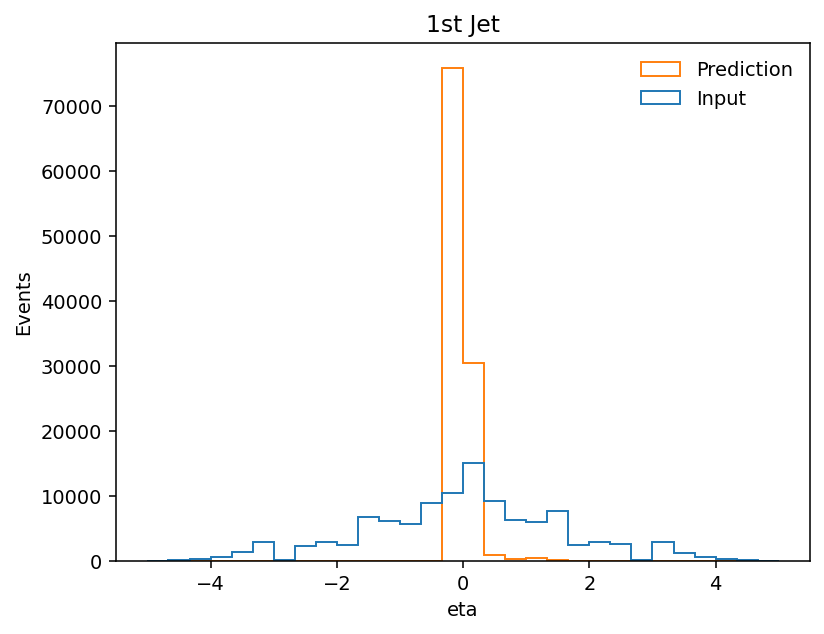

In [35]:
# Eta input vs. predictions
decoded_data = output.reshape(output.shape[0], 4,3)
data_valid_reshaped = data_valid.reshape(data_valid.shape[0], 4,3)

print(decoded_data.shape,data_test.shape, data_valid.shape)

# Prediction isn't great - either model isn't trained well or I am calling the wrong output data
plt.figure()
plt.rcParams['figure.dpi'] = 140
plt.hist([data_valid_reshaped[:,2,1],decoded_data[:,2,1]],bins=30,histtype='step',range = (-5,5), label = ['Input','Prediction'])
plt.xlabel(r"eta")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('1st Jet')

(107889, 4, 3) (107889, 12) (107889, 12)


Text(0.5, 1.0, '1st Jet')

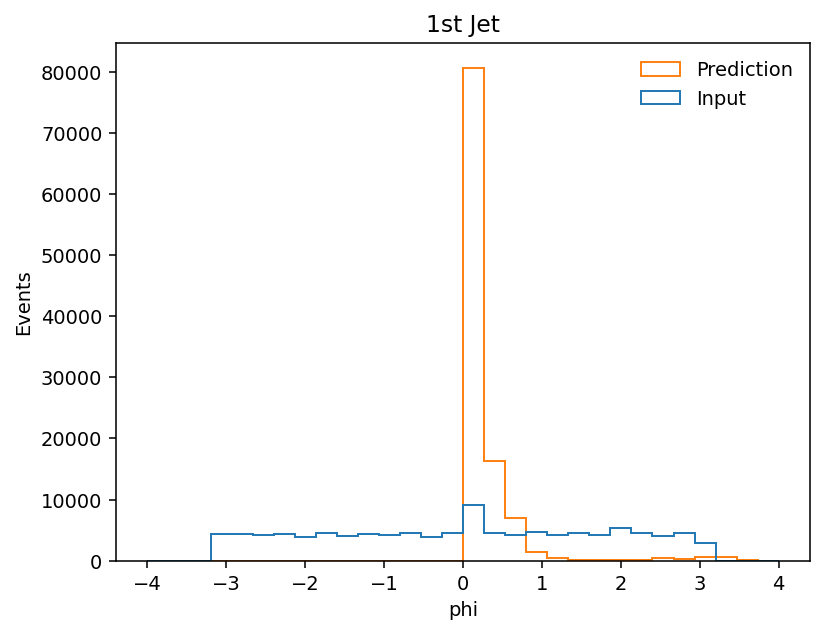

In [36]:
# phi input vs. predictions
decoded_data = output.reshape(output.shape[0], 4,3)
data_valid_reshaped = data_valid.reshape(data_valid.shape[0], 4,3)

print(decoded_data.shape,data_test.shape, data_valid.shape)

# Same thing. [:,0,2] = phi?
plt.figure()
plt.rcParams['figure.dpi'] = 140
plt.hist([data_valid_reshaped[:,3,2],decoded_data[:,3,2]],bins=30,histtype='step',range = (-4,4), label = ['Input','Prediction'])
plt.xlabel(r"phi")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('1st Jet')

**Training model with electrons and muons now!** --> actually just muons rn bc I don't know what electrons to use

In [147]:
#Opening file
filename = "/uscms/home/jpearkes/eos/forAda/scouting_nano.root" # originally from root://hip-cms-se.csc.fi//store/user/pinkaew/scouting_nano_prod_golden/ScoutingPFRun3/crab_ScoutingPFRun3_Run2024D-v1_380385-380470_Golden/240517_205837/0000/scouting_nano_399.root
file = uproot.open(filename)

#Calling files
jet_pt = file["Events"]["L1Jet_pt"].array()
jet_eta = file["Events"]["L1Jet_eta"].array()
jet_phi = file["Events"]["L1Jet_phi"].array()
muon_pt = file["Events"]["L1Mu_pt"].array()
muon_eta = file["Events"]["L1Mu_eta"].array()
muon_phi = file["Events"]["L1Mu_phi"].array()


In [148]:
jet_pt = np.asarray(ak.fill_none(ak.pad_none(jet_pt, 4, clip=True), 0.0)) #replace missing values with none, increase value to target length with ak.pad_none
jet_eta = np.asarray(ak.fill_none(ak.pad_none(jet_eta, 4, clip=True), 0.0))
jet_phi = np.asarray(ak.fill_none(ak.pad_none(jet_phi, 4, clip=True), 0.0))
muon_pt = np.asarray(ak.fill_none(ak.pad_none(muon_pt, 4, clip=True), 0.0)) 
muon_eta = np.asarray(ak.fill_none(ak.pad_none(muon_eta, 4, clip=True), 0.0))
muon_phi = np.asarray(ak.fill_none(ak.pad_none(muon_phi, 4, clip=True), 0.0))

In [151]:
dataset = np.hstack([jet_pt,jet_eta,jet_phi,muon_pt,muon_eta,muon_phi]) #puts all the arrays next to eachother

dataset_size = dataset.shape[0] #gives you number of rows
data_train = dataset[0:int(dataset_size/2)] #50%
data_valid = dataset[int(dataset_size/2):int(dataset_size/4*3)] # 25% - used for tuning hyper-parameters
data_test = dataset[int(dataset_size/4*3):] # 25% - hold out for now

print(data_train.shape,data_test.shape, data_valid.shape)

(215777, 24) (107889, 24) (107889, 24)


In [157]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        print(batch)
        dim = tf.shape(z_mean)[1]
        print(dim)
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
#Encoder

latent_dim = 4

encoder_inputs = keras.Input(shape=(24))
x = layers.Normalization(mean=np.mean(data_train,axis=0),variance=np.std(data_train,axis=0), axis=-1, invert = False)(encoder_inputs)
x1 = layers.Dense(32, activation="relu")(x)
x2 = layers.Dense(16, activation="relu")(x1)
x3 = layers.Dense(8, activation="relu")(x2)
z_mean = layers.Dense(latent_dim, name="z_mean")(x3)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x3)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

#Decoder

latent_inputs = keras.Input(shape=(latent_dim,))
x4 = layers.Dense(16, activation="relu")(latent_inputs)
norm_layer_1 = layers.BatchNormalization(name="norm_1")(x4)
x5 = layers.Dense(32, activation="relu")(norm_layer_1)
norm_layer_2 = layers.BatchNormalization(name="norm_2")(x5)
x6 = layers.Dense(64, activation="relu")(norm_layer_2)
norm_layer_3 = layers.BatchNormalization(name="norm_3")(x6)
x7 = layers.Dense(128, activation="relu")(norm_layer_3)
x8 = layers.Dense(24,kernel_initializer='zeros', activation='linear')(x7)
decoder_outputs = tf.keras.layers.Normalization(mean=np.mean(data_train,axis=0),variance=np.std(data_train,axis=0), axis=-1, invert = True)(x8)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

#Build Model

class VAE(keras.Model):
    def __init__(self, encoder, decoder,alpha = 1, beta = 0.001, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        self.reco_scale = alpha * (1 - beta)
        self.kl_scale = beta
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.total_val_loss_tracker = keras.metrics.Mean(name="total_val_loss")
        self.reconstruction_val_loss_tracker = keras.metrics.Mean(name="val_reco_loss")
        self.kl_val_loss_tracker = keras.metrics.Mean(name="val_kl_loss")


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    

    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            #MSE = keras.losses.MeanSquaredLogarithmicError(reduction="auto", name="mean_squared_error")
            #MSE = keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
            MSE = keras.losses.MeanSquaredError(reduction="none", name="mean_squared_error")
            reconstruction_loss = self.reco_scale * tf.reduce_mean(tf.reduce_sum(MSE(data,reconstruction)))
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = self.kl_scale * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        
        #MSE = keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
        MSE = keras.losses.MeanSquaredError(reduction="none", name="mean_squared_error")
        reconstruction_loss = self.reco_scale* tf.reduce_mean(tf.reduce_sum(MSE(data,reconstruction)))
                    
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = self.kl_scale * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        
        total_loss = reconstruction_loss + kl_loss
        
        self.total_val_loss_tracker.update_state(total_loss)
        self.reconstruction_val_loss_tracker.update_state(reconstruction_loss)
        self.kl_val_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_val_loss_tracker.result(),
            "reco_loss": self.reconstruction_val_loss_tracker.result(),
            "kl_loss": self.kl_val_loss_tracker.result()

      }

Tensor("sampling_3/strided_slice:0", shape=(), dtype=int32)
Tensor("sampling_3/strided_slice_1:0", shape=(), dtype=int32)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 24)]         0           []                               
                                                                                                  
 normalization_9 (Normalization  (None, 24)          0           ['input_10[0][0]']               
 )                                                                                                
                                                                                                  
 dense_24 (Dense)               (None, 32)           800         ['normalization_9[0][0]']        
                                                                     

In [166]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0, patience=5, verbose = 1,restore_best_weights=True)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001,clipnorm=10.0))
history = vae.fit(data_train, validation_data = (data_valid, data_valid), epochs=15, batch_size=16, callbacks = [callback],shuffle=False)

Epoch 1/15
Tensor("encoder/sampling_3/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling_3/strided_slice_1:0", shape=(), dtype=int32)
Tensor("encoder/sampling_3/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling_3/strided_slice_1:0", shape=(), dtype=int32)
13476/13487 [============================>.] - ETA: 0s - loss: 88.1338 - reconstruction_loss: 85.5470 - kl_loss: 0.3497Tensor("encoder/sampling_3/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling_3/strided_slice_1:0", shape=(), dtype=int32)
13487/13487 [==============================] - 31s 2ms/step - loss: 88.1318 - reconstruction_loss: 85.5238 - kl_loss: 0.3496 - val_loss: 89.5961 - val_reco_loss: 89.2546 - val_kl_loss: 0.3416
Epoch 2/15
13487/13487 [==============================] - 28s 2ms/step - loss: 85.4123 - reconstruction_loss: 83.1449 - kl_loss: 0.3313 - val_loss: 87.5421 - val_reco_loss: 87.2085 - val_kl_loss: 0.3336
Epoch 3/15
13487/13487 [==============================] - 27s

In [167]:
z_mean, z_log_var, z = vae.encoder.predict(data_valid)
output = vae.decoder.predict(z)

3372/3372 [==============================] - 2s 715us/step


dict_keys(['loss', 'reconstruction_loss', 'kl_loss', 'val_loss', 'val_reco_loss', 'val_kl_loss'])


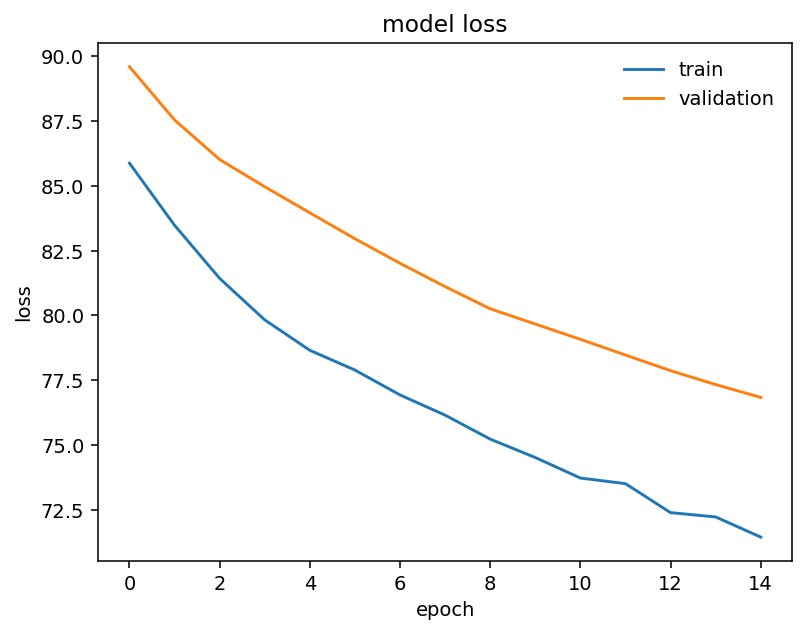

In [168]:
print(history.history.keys())

plt.plot(history.history['loss'],label="train")
plt.plot(history.history['val_loss'],label="validation")
#plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper right',frameon = False)
plt.show()

#This is more the model loss graph I expected above

(107889, 4, 6) (107889, 24) (107889, 24)


Text(0.5, 1.0, '1st Jet')

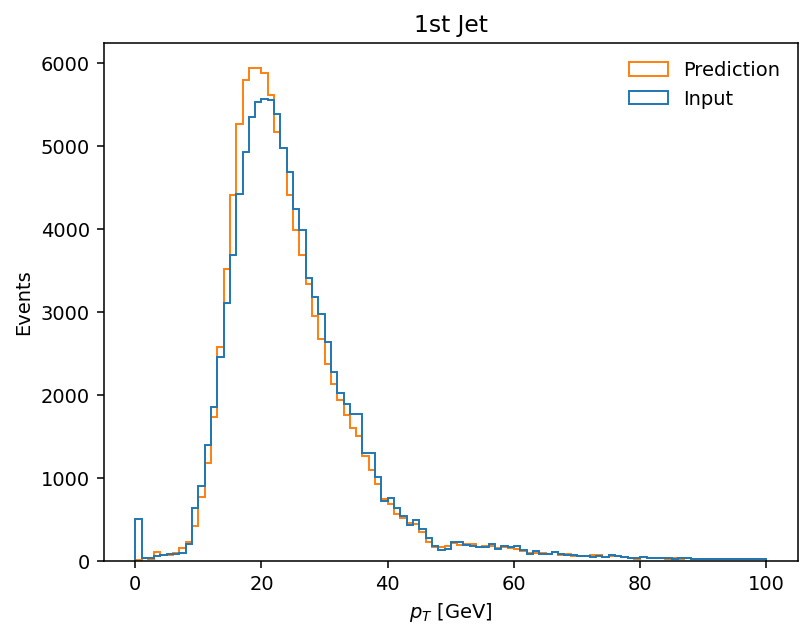

In [170]:
# Need to reshape data slightly differently
decoded_data = output.reshape(output.shape[0], 4,6)
data_valid_reshaped = data_valid.reshape(data_valid.shape[0], 4,6)

print(decoded_data.shape,data_test.shape, data_valid.shape)

#Jet Pt plot
plt.figure()
plt.rcParams['figure.dpi'] = 140
plt.hist([data_valid_reshaped[:,0,0],decoded_data[:,0,0]],bins=100,histtype='step',range = (0,100), label = ['Input','Prediction'])
plt.xlabel(r"$p_T$ [GeV]")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('1st Jet')

# Def worse than before! Is the network confusing what applies to jets vs muons? 